In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. 데이터 로드하기

In [2]:
path_data = 'c:/reposit/data/bigleader/'

train_data = pd.read_table(path_data + 'ratings_train.txt')
test_data = pd.read_table(path_data + 'ratings_test.txt')

In [3]:
print('훈련용 리뷰 개수: ', len(train_data))

훈련용 리뷰 개수:  150000


In [4]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
print('테스트용 리뷰 개수: ', len(test_data))

테스트용 리뷰 개수:  50000


In [6]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2. 데이터 전처리하기

In [7]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [8]:
# 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [9]:
print('총 샘플의 수: ', len(train_data))

총 샘플의 수:  146183


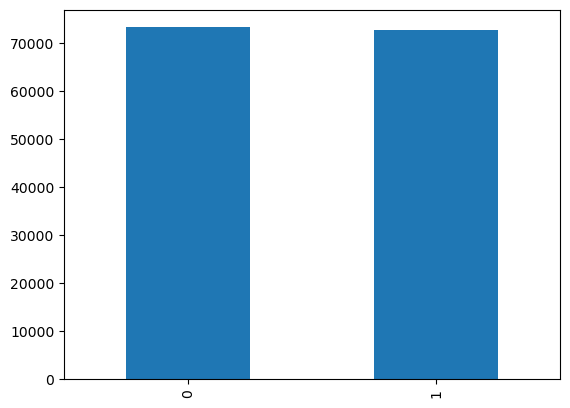

In [10]:
train_data['label'].value_counts().plot(kind='bar')
plt.show()

In [11]:
train_data.groupby('label').size().reset_index(name='count')

,label,count
0,0,73342
1,1,72841


In [12]:
train_data['label'].value_counts().to_frame()

,label
0,73342
1,72841


In [13]:
train_data.isnull().values.any()

True

In [14]:
train_data.isnull().sum().to_frame('nan')

,nan
id,0
document,1
label,0


In [15]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
# null 값 제거
train_data = train_data.dropna(how='any') # Null 값이 조냊하는 행 제거

train_data.isnull().values.any()

False

### 한글과 공백을 제외하고 모두 제거

In [17]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [18]:
# 한글과 공백을 제외하고 모두 제거
train_data = train_data.copy()
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', regex=True)

train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [19]:
# 빈 값을 가진 행 제거
# train_data = train_data.copy()
train_data['document'] = train_data['document'].str.replace('^ +', '', regex=True) # white space 데이터를 empty value로 변경
# train_data = train_data.copy()
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [20]:
train_data.loc[train_data.document.isnull()][:3]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1


In [21]:
# null 값 제거
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [22]:
# test 데이터에서도 앞선 전처리 진행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', '', regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


## 3. 토큰화

In [23]:
# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [24]:
okt = Okt()

okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']

In [25]:
okt = Okt()

okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem=True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [26]:
X_train = []

for sentence in tqdm(train_data['document']):
    
    # 토큰화
    tokenized_sentence = okt.morphs(sentence, stem=True)
    
    # 불용어 제거
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    
    X_train.append(stopwords_removed_sentence)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [27]:
# 테스트 데이터 토큰화
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)


  0%|          | 0/1000 [00:00<?, ?it/s]

## 4. 정수 인코딩

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

len(tokenizer.word_index)

8539

In [29]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 8539
등장 빈도가 2번 이하인 희귀 단어의 수: 5941
단어 집합에서 희귀 단어의 비율: 69.57489167349806
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.356756557889701


In [30]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2599


In [31]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [32]:
print(X_train[:3])

[[57, 689, 14, 218, 870], [749, 399, 42, 570, 1, 193, 1381, 25, 1060, 607, 20], [340, 1382, 2002, 2, 225, 9]]


In [33]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 5. 빈 샘플(empty sample) 제거

In [43]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

drop_train = np.array(drop_train)
type(drop_train)

numpy.ndarray

In [47]:
np.array(X_train, dtype='object')

array([list([57, 689, 14, 218, 870]),
       list([749, 399, 42, 570, 1, 193, 1381, 25, 1060, 607, 20]),
       list([340, 1382, 2002, 2, 225, 9]), ..., list([632, 1146]),
       list([216, 1963, 9, 2326, 827, 36, 2515, 13, 848]),
       list([80, 138, 32, 627, 1316, 73, 26, 613, 287, 46])], dtype=object)

In [48]:
# 빈 샘플들을 제거
X_train = np.delete(np.array(X_train, dtype='object'), drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

4959
145352


리뷰의 최대 길이 : 49
리뷰의 평균 길이 : 9.49808429118774


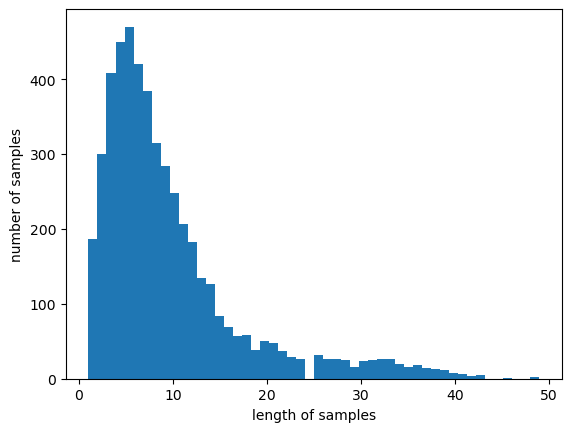

In [49]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [50]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [51]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 96.08792095180479


In [52]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))